In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models

In [ ]:
import os
# os.environ['JAVAHOME'] = 'C:/Program Files/Java/jdk-17.0.1/bin'
# os.environ['STANFORD_PARSER'] = 'C:/stanford-corenlp-4.5.3'
# os.environ['STANFORD_MODELS'] = 'C:/stanford-corenlp-4.5.3'

os.environ['JAVAHOME'] = 'C:/Program Files/Java/jdk1.8.0_361/bin'
os.environ['STANFORD_PARSER'] = 'C:/Program Files/stanford-corenlp-4.5.2/'
os.environ['STANFORD_MODELS'] = 'C:/Program Files/stanford-corenlp-4.5.2/'



In [ ]:
from nltk.parse import CoreNLPParser

pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

### Domain Dictionary

In [ ]:
dict1 = pd.read_csv("suicidal_indicator.csv", header=None).T
dict2 = pd.read_csv("suicidal_ideation.csv", header=None).T
dict3 = pd.read_csv("suicidal_behavior.csv", header=None).T
dict4 = pd.read_csv("suicidal_attempt.csv", header=None).T


In [ ]:
###combined dictionary into 1
domain_dict = pd.concat([dict1, dict2, dict3,dict4], ignore_index=True)
domain_dict = domain_dict.rename(columns={0: 'lexicons'})
domain_dict.head()

In [ ]:
def lower_text(text):
    text = str(text).lower()
    return text

In [ ]:
domain_dict['lexicons'] = domain_dict['lexicons'].apply(lower_text)

In [ ]:
domain_dict

In [ ]:
domain_dict = domain_dict.drop(domain_dict.index[1521]).reset_index(drop=True)

In [ ]:
def stem_preprocess_text(sentence):
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    sentence = str(sentence)
    words = nltk.word_tokenize(sentence.lower())
    tagged_words = pos_tagger.tag(words)
    tagged_words = [(stemmer.stem(word), tag) for word, tag in tagged_words if word not in stop_words]
    return tagged_words

In [ ]:
domain_dict["stem"] = domain_dict["lexicons"].apply(stem_preprocess_text)

In [ ]:
def lem_preprocess_text(sentence):
    stop_words = set(stopwords.words('english'))
#     stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    sentence = str(sentence)
    words = nltk.word_tokenize(sentence.lower())
    tagged_words = pos_tagger.tag(words)
    tagged_words = [(lemmatizer.lemmatize(word), tag) for word, tag in tagged_words if word not in stop_words]
    return tagged_words

In [ ]:
domain_dict["lem"] = domain_dict["lexicons"].apply(lem_preprocess_text)

In [ ]:
domain_dict

In [ ]:
def nested_list_to_string(nested_list):
    return ' '.join(['_'.join(tup) for tup in nested_list])

In [ ]:
domain_dict["stem"] = domain_dict["stem"].apply(nested_list_to_string)
domain_dict["lem"] = domain_dict["lem"].apply(nested_list_to_string)
domain_dict

In [ ]:
## get list of domain dictionary that are stemmed
list_of_stem = []
for i in range (len(domain_dict["stem"])):
    list_of_stem.append(domain_dict["stem"].iloc[i])
len(list_of_stem)

In [ ]:
## get list of domain dictionary that are lemmatized
list_of_lem = []
for j in range (len(domain_dict["lem"])):
    list_of_lem.append(domain_dict["lem"].iloc[j])
len(list_of_lem)

In [ ]:
with open("domain_dict_postag_lem.txt", "w") as file:
    for item in list_of_lem:
        file.write("%s\n" % item)

### POS Tagging


In [ ]:
data = pd.read_csv("preprocessed_data_new.csv")
data.head()

In [ ]:
data.info()

In [ ]:
#drop stemmed_processed_text column
data.drop(columns = ["stemmed_processed_text"], inplace = True)

In [ ]:
#clean and tokenize lemmatized_processed_text as it is intepreted as an entire string 
def clean_and_tokenize(text):
    # Remove the brackets and commas using a regular expression
    cleaned_text = re.sub(r"[\[\],']", "", text)
    # Tokenize the string using word_tokenize
    tokens = word_tokenize(cleaned_text)
    return tokens

In [ ]:
# Apply the function to the 'lemmatized_processed_text' column of the DataFrame
data['tokens'] = data['lemmatized_processed_text'].apply(clean_and_tokenize)

In [ ]:
# Define a function to add POS tags to a list of tokens
def add_pos_tags(tokens):
    tagged_tokens = []
    for token in tokens:
        pos_tag = pos_tagger.tag([token])[0][1]
        tagged_token = f"{token}_{pos_tag}"
        tagged_tokens.append(tagged_token)
    return tagged_tokens

# Apply the function to the 'tokens' column of the DataFrame
data['tagged_tokens'] = data['tokens'].map(add_pos_tags)


In [ ]:
data.head()

In [ ]:
data.to_csv('pos_tagged.csv', index=False)

### combining domain dictionary + POS and creating TF-IDF model


In [2]:
data = pd.read_csv("pos_tagged_new.csv")
data.dropna(inplace=True)

In [3]:
#make a copy of data
data_text = data["text"].copy()

In [4]:
data

,text,class,lemmatized_processed_text,tokens,tagged_tokens
0,ex wife threatening suicide recently i left my...,suicide,"['ex', 'wife', 'threatening', 'suicide', 'rece...","['ex', 'wife', 'threatening', 'suicide', 'rece...","['ex_NN', 'wife_NN', 'threatening_VBG', 'suici..."
1,am i weird i do not get affected by compliment...,non-suicide,"['weird', 'get', 'affected', 'compliment', 'co...","['weird', 'get', 'affected', 'compliment', 'co...","['weird_JJ', 'get_VB', 'affected_VBN', 'compli..."
2,finally is almost over so i can never hear has...,non-suicide,"['finally', 'almost', 'never', 'hear', 'bad', ...","['finally', 'almost', 'never', 'hear', 'bad', ...","['finally_RB', 'almost_RB', 'never_RB', 'hear_..."
3,i need help just help me i am crying so hard,suicide,"['need', 'help', 'help', 'cry', 'hard']","['need', 'help', 'help', 'cry', 'hard']","['need_NN', 'help_NN', 'help_NN', 'cry_NN', 'h..."
4,i m so lost hello my name is adam and i ve bee...,suicide,"['lost', 'hello', 'name', 'adam', 'struggling'...","['lost', 'hello', 'name', 'adam', 'struggling'...","['lost_VBN', 'hello_UH', 'name_NN', 'adam_NN',..."
...,...,...,...,...,...
232069,if you do not like rock then your not going to...,non-suicide,"['like', 'rock', 'going', 'get', 'anything', '...","['like', 'rock', 'going', 'get', 'anything', '...","['like_UH', 'rock_NN', 'going_VBG', 'get_VB', ..."
232070,you how you can tell i have so many friends an...,non-suicide,"['tell', 'many', 'friend', 'lonely', 'everythi...","['tell', 'many', 'friend', 'lonely', 'everythi...","['tell_VB', 'many_JJ', 'friend_NN', 'lonely_JJ..."
232071,pee probably tastes like salty tea can someone...,non-suicide,"['pee', 'probably', 'taste', 'like', 'salty', ...","['pee', 'probably', 'taste', 'like', 'salty', ...","['pee_VB', 'probably_RB', 'taste_NN', 'like_UH..."
232072,the usual stuff you find here i'm not posting ...,suicide,"['usual', 'stuff', 'find', ""'m"", 'posting', 's...","['usual', 'stuff', 'find', '``', 'm', ""''"", 'p...","['usual_JJ', 'stuff_NN', 'find_VB', '``_``', '..."


In [5]:
import ast
data['tagged_tokens'] = data['tagged_tokens'].apply(lambda x: [str(i) for i in ast.literal_eval(x)])


In [6]:
data.drop(columns = ["text","lemmatized_processed_text","tokens"], inplace = True)
data

,class,tagged_tokens
0,suicide,"[ex_NN, wife_NN, threatening_VBG, suicide_NN, ..."
1,non-suicide,"[weird_JJ, get_VB, affected_VBN, compliment_NN..."
2,non-suicide,"[finally_RB, almost_RB, never_RB, hear_VB, bad..."
3,suicide,"[need_NN, help_NN, help_NN, cry_NN, hard_RB]"
4,suicide,"[lost_VBN, hello_UH, name_NN, adam_NN, struggl..."
...,...,...
232069,non-suicide,"[like_UH, rock_NN, going_VBG, get_VB, anything..."
232070,non-suicide,"[tell_VB, many_JJ, friend_NN, lonely_JJ, every..."
232071,non-suicide,"[pee_VB, probably_RB, taste_NN, like_UH, salty..."
232072,suicide,"[usual_JJ, stuff_NN, find_VB, ``_``, m_NN, ''_..."


In [7]:
data["tagged_tokens"] = data["tagged_tokens"].apply(lambda x: " ".join(x))
data.head()

,class,tagged_tokens
0,suicide,ex_NN wife_NN threatening_VBG suicide_NN recen...
1,non-suicide,weird_JJ get_VB affected_VBN compliment_NN com...
2,non-suicide,finally_RB almost_RB never_RB hear_VB bad_JJ y...
3,suicide,need_NN help_NN help_NN cry_NN hard_RB
4,suicide,lost_VBN hello_UH name_NN adam_NN struggling_V...


In [8]:
#importing libraries
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
train_X, test_X, train_y, test_y = train_test_split(data['tagged_tokens'],data['class'],test_size=0.3, random_state = 42)

In [10]:
train_X

13686     losing_VBG grip_NN parent_NN gave_VBD old_JJ n...
60022     hey_UH yy_NNP mean_VB got_VBD sent_VBN right_U...
179581    people_NNS hate_NN much_RB commit_VB die_VB wo...
117440    failing_VBG school_NN might_MD right_UH place_...
90275     like_UH parent_NN ``_`` ''_'' door_NN locked_V...
                                ...                        
119913    get_VB random_JJ fact_NN day_NN decided_VBN ma...
103725                                         situation_NN
131967    know_VB else_RB turn_NN recently_RB got_VBD di...
146907    would_MD like_UH share_NN something_NN watch_N...
121992    every_DT move_NN mistake_NN panic_NN attack_NN...
Name: tagged_tokens, Length: 162411, dtype: object

In [11]:
## get all words from the document with pos_tag

tagged_tokens_list = []
for index, value in train_X.iteritems():
    tagged_tokens_list.append(value)
len(tagged_tokens_list)

162411

In [12]:
##reading the domain dict from the text file
with open("domain_dict_postag_lem.txt", "r") as file:
    list_of_lem = [line.strip() for line in file]

In [13]:
# combining the document and dictionary
tagged_tokens_list.extend(list_of_lem)
len(tagged_tokens_list)

164687

### TF-IDF vectorisation

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
tfidf_vector = tf_idf.fit(tagged_tokens_list)

In [15]:
# Encoder = LabelEncoder()
# train_y = Encoder.fit_transform(train_y)
# test_y = Encoder.fit_transform(test_y)

In [16]:
X_train_tf = tfidf_vector.transform(train_X)
#print dimension of data
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 162411, n_features: 44823


In [17]:
#transforming test data into tf-idf matrix
X_test_tf = tfidf_vector.transform(test_X)

#print dimension of data
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 69606, n_features: 44823


### Word2Vec Vectorisation


In [18]:
import gensim
# Tokenize the text into individual words and create a list for each sentence
sentences = [tagged_tokens.split() for tagged_tokens in tagged_tokens_list]

from gensim.models import Word2Vec
model = Word2Vec(sentences, min_count=1, vector_size=200)

model.save('word2vec.model')

def get_embeddings(text):
    embeddings = []
    tokens = text.split()
    for word in tokens:
        if word in model.wv.key_to_index:
            embeddings.append(model.wv.get_vector(word))
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        # Return a vector of zeros if no embeddings are found
        return np.zeros(model.vector_size)


X_train_w2v = train_X.apply(get_embeddings)
X_train_w2v = np.stack(X_train_w2v.to_numpy())

X_test_w2v = test_X.apply(get_embeddings)
X_test_w2v = np.stack(X_test_w2v.to_numpy())

### sklearn Naive Bayes

In [19]:
#Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, train_y)
#predicted y
y_pred_nb = naive_bayes_classifier.predict(X_test_tf)

In [20]:
print(metrics.classification_report(test_y, y_pred_nb, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.95      0.83      0.88     34757
     Suicide       0.85      0.95      0.90     34849

    accuracy                           0.89     69606
   macro avg       0.90      0.89      0.89     69606
weighted avg       0.90      0.89      0.89     69606



In [21]:
nb_accuracy = accuracy_score(y_pred_nb, test_y)
print("Naive Bayes Accuracy Score -> ", nb_accuracy * 100)

Naive Bayes Accuracy Score ->  89.11588081487228


In [22]:
#Naive Bayes Confusion Matrix
print("Naive Bayes Confusion Matrix:")
print(metrics.confusion_matrix(test_y, y_pred_nb))

Naive Bayes Confusion Matrix:
[[28776  5981]
 [ 1595 33254]]


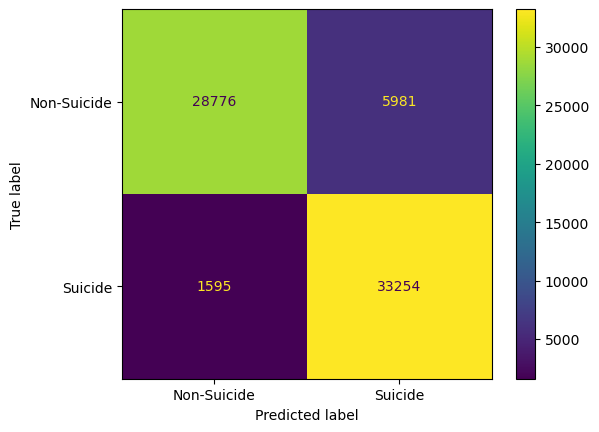

In [23]:
nb_confusion_matrix = metrics.confusion_matrix(test_y, y_pred_nb)

nb_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = nb_confusion_matrix, display_labels = ["Non-Suicide", "Suicide"])

nb_cm_display.plot()
plt.show()

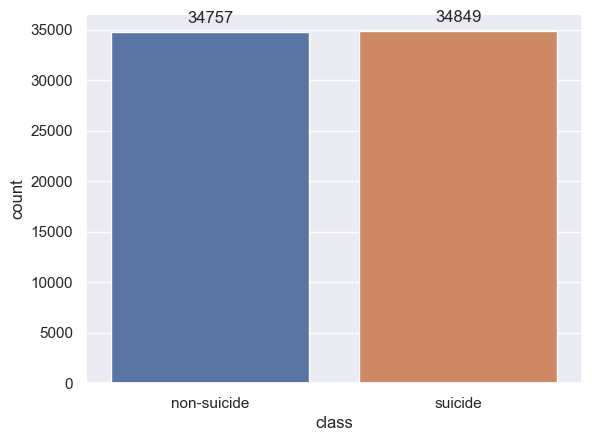

In [24]:
sns.set(style="darkgrid")
ax = sns.countplot(x=test_y)

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()


In [25]:
# convert test_y and y_pred_logreg to numpy arrays
test_y = test_y.to_numpy()
y_pred_nb = np.array(y_pred_nb)

# find misclassified samples
nb_misclassified_indices = [i for i in range(len(test_y)) if test_y[i] != y_pred_nb[i]]
print(len(nb_misclassified_indices))

7576


In [26]:
# create a dataframe with test_X and their true and predicted labels
df_test_nb = pd.DataFrame({'text': test_X, 'true_label': test_y, 'predicted_label': y_pred_nb})

nb_misclassified_df = df_test_nb.iloc[nb_misclassified_indices]

In [27]:
nb_misclassified_df.head()

,text,true_label,predicted_label
28247,depressed_JJ definitely_RB ok_UH recently_RB f...,non-suicide,suicide
25193,help_NN someone_NN killed_VBN themself_RB meg_...,suicide,non-suicide
194706,please_UH think_VB say_UH something_NN online_...,non-suicide,suicide
213094,gain_NN confidence_NN around_RB people_NNS kno...,non-suicide,suicide
25688,professor_NN pulled_VBN aside_RB class_NN toda...,non-suicide,suicide


In [28]:
# merge misclassified_df with data based on the index
nb_misclassified_merged = pd.merge(nb_misclassified_df, data_text, left_index=True, right_index=True)

# print the misclassified texts, true labels, and predicted labels
nb_misclassified_merged_df = pd.DataFrame(nb_misclassified_merged[['text_y', 'true_label', 'predicted_label']])

In [29]:
nb_misclassified_merged_df.to_csv("misclassified_naive_bayes.csv")

### Logistic Regression

In [30]:
# fit the training dataset on the Logistic Regression classifier
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_tf,train_y)
# predict the labels on validation dataset
y_pred_logreg = logreg.predict(X_test_tf)

In [31]:
print(metrics.classification_report(test_y, y_pred_logreg, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.95      0.94     34757
     Suicide       0.95      0.93      0.94     34849

    accuracy                           0.94     69606
   macro avg       0.94      0.94      0.94     69606
weighted avg       0.94      0.94      0.94     69606



In [32]:
logreg_accuracy = accuracy_score(y_pred_logreg, test_y)
print("Logistic Regression Accuracy Score -> ", logreg_accuracy * 100)

Logistic Regression Accuracy Score ->  93.73329885354711


In [33]:
#Log Reg Confusion Matrix
print("Logistic Regression Confusion Matrix:")
print(metrics.confusion_matrix(test_y, y_pred_logreg))

Logistic Regression Confusion Matrix:
[[32919  1838]
 [ 2524 32325]]


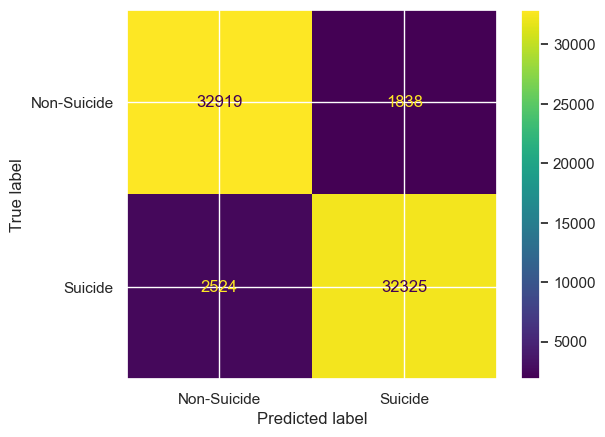

In [34]:
logreg_confusion_matrix = metrics.confusion_matrix(test_y, y_pred_logreg)

logreg_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = logreg_confusion_matrix, display_labels = ["Non-Suicide", "Suicide"])

logreg_cm_display.plot()
plt.show()

In [35]:
# convert test_y and y_pred_logreg to numpy arrays
y_pred_logreg = np.array(y_pred_logreg)

# find misclassified samples
logreg_misclassified_indices = [i for i in range(len(test_y)) if test_y[i] != y_pred_logreg[i]]
print(len(logreg_misclassified_indices))

4362


In [36]:
# create a dataframe with test_X and their true and predicted labels
df_test_logreg = pd.DataFrame({'text': test_X, 'true_label': test_y, 'predicted_label': y_pred_logreg})

logreg_misclassified_df = df_test_logreg.iloc[logreg_misclassified_indices]

In [37]:
logreg_misclassified_df.head()

,text,true_label,predicted_label
25193,help_NN someone_NN killed_VBN themself_RB meg_...,suicide,non-suicide
194706,please_UH think_VB say_UH something_NN online_...,non-suicide,suicide
664,adopt_VB mep_NN l_NN,suicide,non-suicide
44196,know_VB need_NN help_NN trust_NN anyone_NN exp...,suicide,non-suicide
169038,anyone_NN else_RB think_VB deserve_VB live_RB,non-suicide,suicide


In [38]:
# merge misclassified_df with data based on the index
logreg_misclassified_merged = pd.merge(logreg_misclassified_df, data_text, left_index=True, right_index=True)

# print the misclassified texts, true labels, and predicted labels
logreg_misclassified_merged_df = pd.DataFrame(logreg_misclassified_merged[['text_y', 'true_label', 'predicted_label']])

In [39]:
logreg_misclassified_merged_df.to_csv("misclassified_logistic_regression.csv")

#### Word2Vec

In [40]:
# fit the training dataset on the Logistic Regression classifier
logreg_w2v = LogisticRegression(max_iter=200)
logreg_w2v.fit(X_train_w2v,train_y)
# predict the labels on validation dataset
y_pred_logreg_w2v = logreg_w2v.predict(X_test_w2v)

In [41]:
print(metrics.classification_report(test_y, y_pred_logreg_w2v, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.92      0.90      0.91     34757
     Suicide       0.90      0.93      0.91     34849

    accuracy                           0.91     69606
   macro avg       0.91      0.91      0.91     69606
weighted avg       0.91      0.91      0.91     69606



In [42]:
logreg_accuracy_w2v = accuracy_score(y_pred_logreg_w2v, test_y)
print("Logistic Regression for Word2Vec Accuracy Score -> ", logreg_accuracy_w2v * 100)

Logistic Regression for Word2Vec Accuracy Score ->  91.28379737378962


### SVM

In [43]:
# fit the training dataset on the SVM classifier
linearSVC = LinearSVC()
linearSVC.fit(X_train_tf,train_y)
# predict the labels on validation dataset
y_pred_SVC = linearSVC.predict(X_test_tf)


In [44]:
print(metrics.classification_report(test_y, y_pred_SVC, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.94      0.94     34757
     Suicide       0.94      0.93      0.94     34849

    accuracy                           0.94     69606
   macro avg       0.94      0.94      0.94     69606
weighted avg       0.94      0.94      0.94     69606



In [45]:
svc_accuracy = accuracy_score(y_pred_SVC, test_y)
print("SVM Accuracy Score -> ",svc_accuracy*100)

SVM Accuracy Score ->  93.61118294399908


In [46]:
#SVM Confusion Matrix
print("SVM Confusion Matrix:")
print(metrics.confusion_matrix(test_y, y_pred_SVC))

SVM Confusion Matrix:
[[32782  1975]
 [ 2472 32377]]


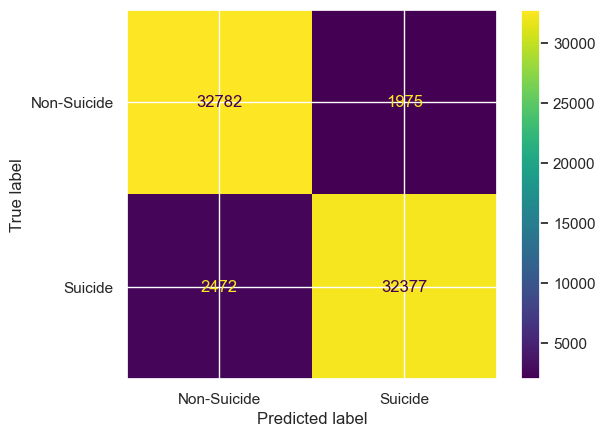

In [47]:
svc_confusion_matrix = metrics.confusion_matrix(test_y, y_pred_SVC)

svc_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = svc_confusion_matrix, display_labels = ["Non-Suicide", "Suicide"])

svc_cm_display.plot()
plt.show()

In [48]:
# convert test_y and y_pred_logreg to numpy arrays
y_pred_SVC = np.array(y_pred_SVC)

# find misclassified samples
svc_misclassified_indices = [i for i in range(len(test_y)) if test_y[i] != y_pred_SVC[i]]
print(len(svc_misclassified_indices))

4447


In [49]:
# create a dataframe with test_X and their true and predicted labels
df_test_SVC = pd.DataFrame({'text': test_X, 'true_label': test_y, 'predicted_label': y_pred_SVC})

SVC_misclassified_df = df_test_SVC.iloc[svc_misclassified_indices]

In [50]:
SVC_misclassified_df.head()

,text,true_label,predicted_label
25193,help_NN someone_NN killed_VBN themself_RB meg_...,suicide,non-suicide
194706,please_UH think_VB say_UH something_NN online_...,non-suicide,suicide
664,adopt_VB mep_NN l_NN,suicide,non-suicide
44196,know_VB need_NN help_NN trust_NN anyone_NN exp...,suicide,non-suicide
169038,anyone_NN else_RB think_VB deserve_VB live_RB,non-suicide,suicide


In [51]:
# merge misclassified_df with data based on the index
SVC_misclassified_merged = pd.merge(SVC_misclassified_df, data_text, left_index=True, right_index=True)

# print the misclassified texts, true labels, and predicted labels
SVC_misclassified_merged_df = pd.DataFrame(SVC_misclassified_merged[['text_y', 'true_label', 'predicted_label']])

In [52]:
SVC_misclassified_merged_df.to_csv("misclassified_SVM.csv")

#### Word2Vec

In [62]:
# fit the training dataset on the SVM classifier
linearSVC_w2v = LinearSVC(dual=False)
linearSVC_w2v.fit(X_train_w2v,train_y)
# predict the labels on validation dataset
y_pred_SVC_w2v = linearSVC_w2v.predict(X_test_w2v)


In [63]:
print(metrics.classification_report(test_y, y_pred_SVC_w2v, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.89      0.91     34757
     Suicide       0.90      0.93      0.91     34849

    accuracy                           0.91     69606
   macro avg       0.91      0.91      0.91     69606
weighted avg       0.91      0.91      0.91     69606



In [64]:
svc_accuracy_w2v = accuracy_score(y_pred_SVC_w2v, test_y)
print("SVM for Word2Vec Accuracy Score -> ",svc_accuracy_w2v*100)

SVM for Word2Vec Accuracy Score ->  91.12145504697871


### Compare the Models

In [65]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred contain the true and predicted labels
nb_report_dict = metrics.classification_report(test_y, y_pred_nb, target_names=['Non-Suicide', 'Suicide'], output_dict=True)
logreg_report_dict = metrics.classification_report(test_y, y_pred_logreg, target_names=['Non-Suicide', 'Suicide'], output_dict=True)
svc_report_dict = metrics.classification_report(test_y, y_pred_SVC, target_names=['Non-Suicide', 'Suicide'], output_dict=True)


# Extract precision, recall, and f1-score for the "Suicide" class i each dictionary
nb_precision = nb_report_dict['Suicide']['precision']
nb_recall = nb_report_dict['Suicide']['recall']
nb_f1_score = nb_report_dict['Suicide']['f1-score']

logreg_precision = logreg_report_dict['Suicide']['precision']
logreg_recall = logreg_report_dict['Suicide']['recall']
logreg_f1_score = logreg_report_dict['Suicide']['f1-score']

svc_precision = svc_report_dict['Suicide']['precision']
svc_recall = svc_report_dict['Suicide']['recall']
svc_f1_score = svc_report_dict['Suicide']['f1-score']




In [66]:
#put all the values into a dictionary

suicide_scores = {
    'Naive Bayes': {
        'precision': nb_precision,
        'recall':nb_recall,
        'f1_score': nb_f1_score,
        'accuracy': nb_accuracy
    },
    'Logistic Regression': {
        'precision': logreg_precision,
        'recall': logreg_recall,
        'f1_score': logreg_f1_score,
        'accuracy': logreg_accuracy
    },
    'Support Vector Machine': {
        'precision': svc_precision,
        'recall': svc_recall,
        'f1_score': svc_f1_score,
        'accuracy': svc_accuracy
    }
}


In [67]:
suicide_scores = {
    model: {metric: round(score, 2) for metric, score in scores.items()} 
    for model, scores in suicide_scores.items()
}

suicide_scores


{'Naive Bayes': {'precision': 0.85,
  'recall': 0.95,
  'f1_score': 0.9,
  'accuracy': 0.89},
 'Logistic Regression': {'precision': 0.95,
  'recall': 0.93,
  'f1_score': 0.94,
  'accuracy': 0.94},
 'Support Vector Machine': {'precision': 0.94,
  'recall': 0.93,
  'f1_score': 0.94,
  'accuracy': 0.94}}

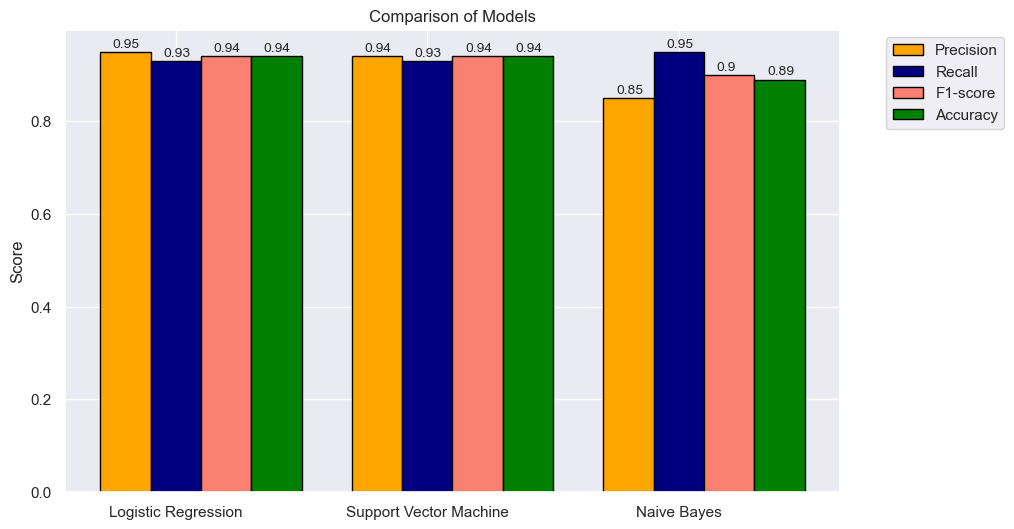

In [68]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a list of the model names
model_names = ['Naive Bayes', 'Logistic Regression', 'Support Vector Machine']

# Create a list of the precision scores
precision_scores = [suicide_scores[model]['precision'] for model in model_names]

# Create a list of the recall scores
recall_scores = [suicide_scores[model]['recall'] for model in model_names]

# Create a list of the F1-scores
f1_scores = [suicide_scores[model]['f1_score'] for model in model_names]

# Create a list of the accuracy scores
accuracy_scores = [suicide_scores[model]['accuracy'] for model in model_names]

# Sort the model names and scores by accuracy
sorted_scores = sorted(zip(model_names, precision_scores, recall_scores, f1_scores, accuracy_scores), key=lambda x: x[4], reverse=True)
model_names, precision_scores, recall_scores, f1_scores, accuracy_scores = zip(*sorted_scores)

# Set the width of the bars
bar_width = 0.2

# Set the x-axis positions for the bars
r1 = range(len(precision_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot the bars for precision, recall, F1-score, and accuracy
# Plot the bars for precision, recall, F1-score, and accuracy
plt.bar(r1, precision_scores, color='orange', width=bar_width, edgecolor='black', label='Precision')
plt.bar(r2, recall_scores, color='navy', width=bar_width, edgecolor='black', label='Recall')
plt.bar(r3, f1_scores, color='salmon', width=bar_width, edgecolor='black', label='F1-score')
plt.bar(r4, accuracy_scores, color='green', width=bar_width, edgecolor='black', label='Accuracy')

# Add data labels above each bar
for i, score in enumerate(zip(precision_scores, recall_scores, f1_scores, accuracy_scores)):
    plt.text(r1[i]-0.05, score[0]+0.01, round(score[0],2), fontsize=10)
    plt.text(r2[i]-0.05, score[1]+0.01, round(score[1],2), fontsize=10)
    plt.text(r3[i]-0.05, score[2]+0.01, round(score[2],2), fontsize=10)
    plt.text(r4[i]-0.05, score[3]+0.01, round(score[3],2), fontsize=10)

# Set the x-axis labels and tick positions
plt.xticks([r + bar_width for r in range(len(precision_scores))], model_names)

plt.title("Comparison of Models")


# Add a legend and set the y-axis label
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Score')

# Show the plot
plt.show()


### Test Sample Prediction

In [69]:
#sample prediction
test = ['i want to die. cannot live any longer. help']

In [70]:
review = re.sub('[^a-zA-Z]', ' ', test[0])
review = review.lower()
review = review.split()
stop_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
review = [lemmatizer.lemmatize(word) for word in review if not word in stop_list]

In [71]:
# Create a function to add POS tags in the form of word_POS
def add_pos_tag(sentences):
    tagged_sentences = []
    for sentence in sentences:
        # Tokenize sentence into words
        words = nltk.word_tokenize(sentence)
        # Get POS tags for words
        pos_tags = nltk.pos_tag(words)
        # Join word and POS tag into word_POS format
        tagged_words = [f"{word}_{pos}" for word, pos in pos_tags]
        # Join tagged words into sentence
        tagged_sentence = " ".join(tagged_words)
        # Add tagged sentence to list
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

test_tagged = add_pos_tag(review)
print(test_tagged)

['want_NN', 'die_NN', 'can_MD not_RB', 'live_JJ', 'longer_NN', 'help_NN']


In [72]:
test_processed =[ ' '.join(test_tagged)]
test_processed

['want_NN die_NN can_MD not_RB live_JJ longer_NN help_NN']

In [73]:
test_input = tf_idf.transform(test_processed)
test_input.shape

(1, 44823)

In [74]:
#sklearn Naive Bayes
nb_result = naive_bayes_classifier.predict(test_input)[0]
nb_result

'suicide'

In [75]:
#LogReg
logreg_result = logreg.predict(test_input)[0]
logreg_result

'suicide'

In [76]:
#SVM
SVC_result = linearSVC.predict(test_input)[0]
SVC_result

'suicide'